## Fastbook Sandbox

In [1]:
import torch
from fastai.vision.all import *
from fastbook import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:

ex = torch.rand(2, 2, 2)* 0.5
ax = torch.rand(2, 2, 2)* -1
print(ex.shape)
print(ax.shape)
ax

torch.Size([2, 2, 2])
torch.Size([2, 2, 2])


tensor([[[-0.9408, -0.1332],
         [-0.9346, -0.5936]],

        [[-0.8694, -0.5677],
         [-0.7411, -0.4294]]])

In [3]:
def mnist_distance(a,b): return (b-a).abs().mean()
mnist_distance(ex, ax)

tensor(0.9750)

## Pytorch can derivate any function in any point

In [4]:
xt = torch.tensor(3.).requires_grad_()

In [5]:
def f(x): return x**2
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [6]:
yt.backward()

In [7]:
xt.grad

tensor(6.)

In [8]:
xt = torch.tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [9]:
def f(x): return (x**2).sum()
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [10]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

## SDG quadratic example
This is a example of the speed of a roller coaster:
 ```python
 speed = f(t)
 ```
 We are going to need a tensor for the **time** and another for the **speed**.

In [19]:
# This is the time:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

In [20]:
# torch.randn(*size, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) → Tensor
# Returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1 (also called the standard normal distribution).
torch.randn(20)*3

tensor([ 5.7807,  4.4619,  2.7022, -6.3166, -2.2744,  3.2350,  2.4024,  5.0419,  1.0676, -2.0599, -1.4801,  0.7245, -0.6949,  0.1253, -0.7547,  2.5796, -0.9292, -1.1871,  2.4102, -1.8648])

In [21]:
# This is the speed as a function of the time:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
speed

tensor([69.6441, 53.9139, 44.1047, 30.3637, 21.1761, 13.4203, 15.6215,  6.1692,  3.7892,  1.7137,  5.3430,  1.3499,  2.0802, 12.3109, 12.9598, 25.2945, 36.2136, 44.8710, 53.8293, 66.3722])

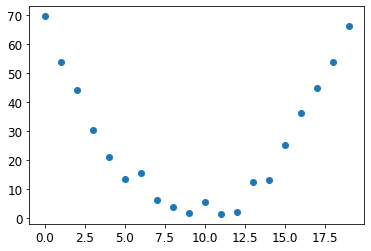

In [22]:
plt.scatter(time,speed);

It is selected a quadratic function to describe the behavior of speed using 3 parameters:

In [23]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

It is chosen a **loss function** to analyze the accuracy of the aproximation using mean square error:

In [24]:
def mse(preds, targets): return ((preds-targets)**2).mean()

**Step 1**
Initialization of parameters randomly:<br>
<br>
We indicate Pytorch that the tensor will need gradients to be calculated in the future.

In [25]:
params = torch.randn(3).requires_grad_()
params

tensor([ 0.1498, -0.2089, -0.3870], requires_grad=True)

Keep the original weights for future calculations:

In [26]:
#hide
orig_params = params.clone()
orig_params

tensor([ 0.1498, -0.2089, -0.3870], grad_fn=<CloneBackward>)

**Step 2**
Calculate the predictions:

In [27]:
preds = f(time, params)

Function to see how close our predictions are to our targets:

In [28]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

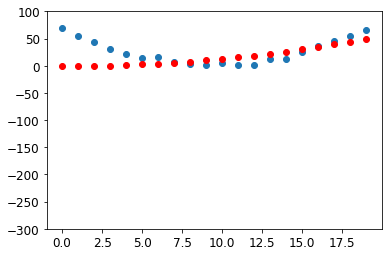

In [29]:
show_preds(preds)

**Step 3**
Calculate the loss:

In [36]:
loss = mse(preds, speed)
loss

tensor(634.3898, grad_fn=<MeanBackward0>)

**Step 4**
Calculate the gradients of the loss:

In [28]:
loss.backward()
params.grad

tensor([43323.4453,  2758.8596,   166.9708])

The gradients are multiply by the learning rate:

In [29]:
params.grad * 1e-5

tensor([0.4332, 0.0276, 0.0017])

In [30]:
params

tensor([ 0.9912, -1.3297, -0.5426], requires_grad=True)

**Step 5** Step the weights:
Meaning that we change the weights based on the gradient and the lerning rate.

In [32]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

We check the precusion with adjusted parameters:

In [33]:
preds = f(time,params)
mse(preds, speed)

tensor(3842.2026, grad_fn=<MeanBackward0>)

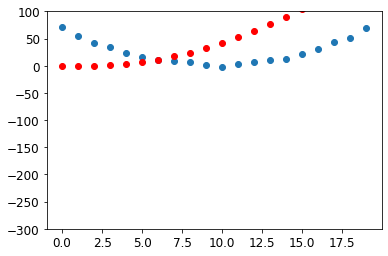

In [34]:
show_preds(preds)

We define a new function that executes the steps that will be repeated:

In [35]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

In [ ]:
**Step 6** Repeat the process:

In [36]:
for i in range(10): apply_step(params)

3842.20263671875
1283.4613037109375
799.2611694335938
707.6275024414062
690.2796020507812
686.9886474609375
686.3577270507812
686.2302856445312
686.1979370117188
686.1837158203125


In [37]:
params = orig_params.detach().requires_grad_()

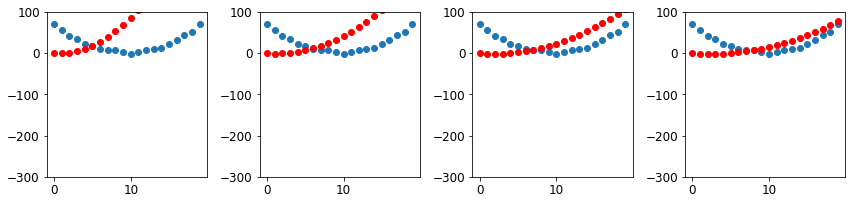

In [38]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

**Step 7**
Stop.

In [19]:
r = torch.tensor([1]*len(ex) + [0]*len(ax)).unsqueeze(1)
r

tensor([[1],
        [1],
        [0],
        [0]])

The zip() function returns a zip object, which is an iterator of tuples where the first item in each passed iterator is paired together, and then the second item in each passed iterator are paired together etc.

In [20]:
qx = torch.rand(2,2)* 0.5
px = torch.rand(2,2)* -1
dset = list(zip(qx, px))
dset


[(tensor([0.0818, 0.3513]), tensor([-0.2418, -0.1591])),
 (tensor([0.3395, 0.4577]), tensor([-0.7653, -0.2979]))]

In [21]:
list(ex)
x,y = dset[0]
x, y

(tensor([0.0818, 0.3513]), tensor([-0.2418, -0.1591]))

## Matrix Multiplication

In Python, matrix multiplication is represented with the @ operator.

In [22]:
r = x@y
r

tensor(-0.0757)

In [23]:
r = 1/(1+torch.exp(-x))
r

tensor([0.5204, 0.5869])

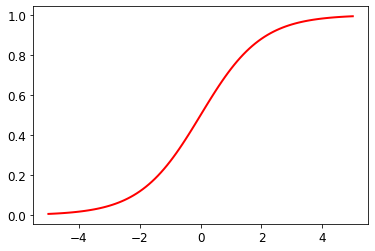

In [24]:
x = torch.range(-5,5,0.1)
def sigmoid(x): return 1/(1+torch.exp(-x))
plt.plot(x, sigmoid(x), color='red', lw=2)

In [25]:
a = np.array([[1, 2],[3, 4]])
b = np.array([[5, 6],[7, 8]])
print(a@b)
print(np.matmul(a,b))
print(np.dot(a,b))
print(a*b)

[[19 22]
 [43 50]]
[[19 22]
 [43 50]]
[[19 22]
 [43 50]]
[[ 5 12]
 [21 32]]


In [26]:
a = torch.tensor([[1, 2, 3],[3, 4, 5]])
print('a.size() ', a.size())
#print('a.shape() ',a.shape())
#print('Rank: ' len(a.shape)
b = torch.tensor([[5, 6],[7, 8],[9, 10]])
c = torch.tensor([[5, 6, 7], [8, 9, 10]])
print('b.size() ', b.size())
print('c.size() ', c.size())
print(a@b)
print(torch.mm(a,b))
print(torch.matmul(a,b))
# print(a*b) element-wise matrix multiplication (Hadamard product).  Works if shape is the same for a and b
print(a*c)
ac = a*c
print('ac.size() ', ac.size())

a.size()  torch.Size([2, 3])
b.size()  torch.Size([3, 2])
c.size()  torch.Size([2, 3])
tensor([[ 46,  52],
        [ 88, 100]])
tensor([[ 46,  52],
        [ 88, 100]])
tensor([[ 46,  52],
        [ 88, 100]])
tensor([[ 5, 12, 21],
        [24, 36, 50]])
ac.size()  torch.Size([2, 3])


```python
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()
```

## DataLoader <br>
A DataLoader can take any Python collection and turn it into an iterator over many batches, like so:

In [36]:
coll = range(20)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 5,  9,  8, 15,  4]),
 tensor([16,  0, 12, 18,  6]),
 tensor([19,  3, 17, 11,  1]),
 tensor([ 2, 13,  7, 10, 14])]

In [2]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [3]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 7, 24, 17, 21,  5, 19]), ('h', 'y', 'r', 'v', 'f', 't')),
 (tensor([ 9, 15, 14,  4, 16,  0]), ('j', 'p', 'o', 'e', 'q', 'a')),
 (tensor([22, 13, 25,  3,  2, 11]), ('w', 'n', 'z', 'd', 'c', 'l')),
 (tensor([12, 23,  1, 10,  8, 20]), ('m', 'x', 'b', 'k', 'i', 'u')),
 (tensor([18,  6]), ('s', 'g'))]

In [4]:
torch.randperm(10)[:3]

tensor([6, 5, 4])

In [15]:
a = [(1, 0.4), (2, 0.5), (3, 0.3), (4, 0.1), (5, 0.4), (6, 0.2), (7, 0.3), (8, 0.1)]
tex = torch.tensor(a)

In [27]:
dl = DataLoader(tex, batch_size=2, shuffle=True)
print(list(dl))
xb,yb = first(dl)
xb.shape,yb.shape
yb

[tensor([[5.0000, 0.4000],
        [2.0000, 0.5000]]), tensor([[4.0000, 0.1000],
        [3.0000, 0.3000]]), tensor([[8.0000, 0.1000],
        [6.0000, 0.2000]]), tensor([[1.0000, 0.4000],
        [7.0000, 0.3000]])]


tensor([4.0000, 0.1000])

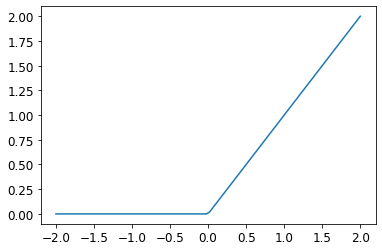

In [28]:
plot_function(F.relu)

In [ ]:
Create a function that, if passed two arguments [1,2,3,4] and 'abcd', returns [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]. What is special about that output data structure?

In [1]:
??zip

Init signature: zip(self, /, *args, **kwargs)
Docstring:     
zip(*iterables) --> A zip object yielding tuples until an input is exhausted.

   >>> list(zip('abcdefg', range(3), range(4)))
   [('a', 0, 0), ('b', 1, 1), ('c', 2, 2)]

The zip object yields n-length tuples, where n is the number of iterables
passed as positional arguments to zip().  The i-th element in every tuple
comes from the i-th iterable argument to zip().  This continues until the
shortest argument is exhausted.
Type:           type
Subclasses:     


In [2]:
list(zip([1,2,3,4],'abcd'))

[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]

What does view do in Pytorch?

In [9]:
a = torch.range(1, 16)
a

tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.])

In [10]:
a.view(4,4)

tensor([[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]])

**view** reshapes a tensor.

## Debugging
The standard Python distribution includes a module named pdb, which provides debugging support directly within the interpreter. 

Member functions = Methods
<br>
Attributes = fields, instance variables, or data members

# 05 Pet breeds


## Softmax

In [2]:
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)

In [17]:
acts = torch.randn((6,2))*2
acts

tensor([[-1.8455, -1.4580],
        [ 1.4554, -0.0143],
        [-1.9558,  2.0080],
        [-0.0495,  0.2945],
        [-0.2605, -1.5103],
        [-1.2726, -1.3691]])

In [23]:
x,y = torch.transpose(acts, 0, 1)
x

tensor([-1.8455,  1.4554, -1.9558, -0.0495, -0.2605, -1.2726])

In [24]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.4043, 0.8130, 0.0186, 0.4148, 0.7773, 0.5241])

In [29]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.4043, 0.5957],
        [0.8130, 0.1870],
        [0.0186, 0.9814],
        [0.4148, 0.5852],
        [0.7773, 0.2227],
        [0.5241, 0.4759]])